# 线性回归

## what

思想：用一条直线拟合样本点，让残差平方和最小。

模型：$h(x)=X\theta$

参数：$\theta=(\theta_0,...,\theta_n)^{'}$

目标函数：$J(\theta)=\frac{1}{2m}\sum^{m}_{i=1}(y^{(i)}-h(x^{(i)}))^2=\frac{1}{2m}||y-X\theta||_2^2$

梯度：$\bigtriangledown J(\theta)=\frac{1}{m}X^T(h(x)-y)$

最优参数：$\hat{\theta}=(X^TX)^{-1}X^Ty$

优点：
1. 建模速度快，不需要很复杂的计算，在数据量大的情况下依然运行速度很快。
2. 可以根据系数给出每个变量的解释

缺点：
1. 不能很好地拟合非线性数据。所以需要先判断变量之间是否是线性关系。

## how

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import kstest # 正态性检验

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 数据

In [2]:
train = pd.read_csv('california_housing_train.csv')
test = pd.read_csv('california_housing_test.csv')
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [3]:
# 线性假定
train.corr()['median_house_value']

longitude            -0.044982
latitude             -0.144917
housing_median_age    0.106758
total_rooms           0.130991
total_bedrooms        0.045783
population           -0.027850
households            0.061031
median_income         0.691871
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [4]:
# 无严格多重共线性
train.drop(columns='median_house_value').corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.000000,-0.925208,-0.114250,0.047010,0.071802,0.101674,0.059628,-0.015485
latitude,-0.925208,1.000000,0.016454,-0.038773,-0.069373,-0.111261,-0.074902,-0.080303
housing_median_age,-0.114250,0.016454,1.000000,-0.360984,-0.320434,-0.295890,-0.302754,-0.115932
total_rooms,0.047010,-0.038773,-0.360984,1.000000,0.928403,0.860170,0.919018,0.195383
total_bedrooms,0.071802,-0.069373,-0.320434,0.928403,1.000000,0.881169,0.980920,-0.013495
population,0.101674,-0.111261,-0.295890,0.860170,0.881169,1.000000,0.909247,-0.000638
households,0.059628,-0.074902,-0.302754,0.919018,0.980920,0.909247,1.000000,0.007644
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.013495,-0.000638,0.007644,1.000000


In [5]:
train.drop(columns=['longitude', 'total_bedrooms', 'population', 'households'], inplace=True)
test = test[train.columns]

In [6]:
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

### 模型

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5014286582077965

In [8]:
# 残差检验
e = y_test - model.predict(X_test)

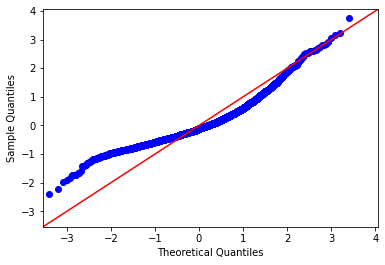

In [9]:
qqplot(e, line='45')
plt.show()

In [10]:
kstest(e, 'norm')

KstestResult(statistic=0.15288164777495256, pvalue=2.4944006873754828e-61)

## why

In [11]:
class myLinReg():
    def __init__(self, eta=1e-1, thread=1e-3, max_iter=1000):
        self._X = None
        self._y = None
        self._theta = None
        self._eta = eta
        self._thread = thread
        self._max_iter = max_iter
        
    def fit(self, X_train, y_train):
        self._X = np.c_[np.ones(X_train.shape[0]), X_train]
        self._y = np.array(y_train).reshape(-1, 1)
        self._theta = np.linalg.inv(self._X.T @ self._X) @ self._X.T @ self._y
    
    # 目标函数
    def _J(self):
        h = self._X @ self._theta
        m = len(self._y)
        return np.sum((self._y - h)**2) / 2*m
    
    # 梯度
    def _dJ(self):
        h = self._X @ self._theta
        m = len(self._y)
        return (self._X.T @ (h - self._y)) / m
    
    def fit_gd(self, X_train, y_train):
        self._X = np.c_[np.ones(X_train.shape[0]), X_train]
        self._y = np.array(y_train).reshape(-1, 1)
        self._theta = np.zeros(self._X.shape[1]).reshape(-1,1)
        count = 1
        while count < self._max_iter:
            old_J = self._J()
            dJ = self._dJ()
            self._theta -= self._eta * dJ
            new_J = self._J()
            if np.abs(new_J - old_J) < self._thread:
                break
            count +=1
        return self
    
    def predict(self, X_test):
        X_b = np.c_[np.ones(X_test.shape[0]), X_test]
        return X_b @ self._theta
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1,1)
        y_test = np.array(y_test).reshape(-1,1)
        sse = np.sum((y_test - y_pred)**2)
        sst = np.sum((y_test - y_test.mean())**2)
        return 1 - sse/sst

In [14]:
myModel = myLinReg()
myModel.fit(X_train, y_train)
myModel.score(X_test, y_test)

0.5014286582077965